In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score,roc_auc_score,roc_curve,classification_report,precision_recall_curve,auc, plot_precision_recall_curve,f1_score
from sklearn import metrics
import matplotlib.pyplot as plt
import xgboost
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv("NC_policing.csv")
df.head()

,state,stop_date,driver_gender,driver_age,driver_race_raw,driver_race,violation,search_type,contraband_found,stop_outcome,search_basis,officer_id,drugs_related_stop,district
0,NC,2000-07-31,M,23.0,W N,White,Speeding,No Search Conducted,False,Arrest,No Search Conducted,10606,NaN,E3
1,NC,2000-07-31,F,29.0,W N,White,Speeding,No Search Conducted,False,Arrest,No Search Conducted,10606,NaN,E3
2,NC,2000-07-31,F,49.0,B N,Black,Speeding,No Search Conducted,False,Arrest,No Search Conducted,10606,NaN,E3
3,NC,2000-07-31,M,29.0,B N,Black,Speeding,No Search Conducted,False,Arrest,No Search Conducted,10606,NaN,E3
4,NC,2000-07-31,M,24.0,U H,Hispanic,Speeding,No Search Conducted,False,Arrest,No Search Conducted,10606,NaN,E3


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402087 entries, 0 to 402086
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   state               402087 non-null  object 
 1   stop_date           402087 non-null  object 
 2   driver_gender       402087 non-null  object 
 3   driver_age          401996 non-null  float64
 4   driver_race_raw     402087 non-null  object 
 5   driver_race         402087 non-null  object 
 6   violation           402087 non-null  object 
 7   search_type         402087 non-null  object 
 8   contraband_found    402087 non-null  bool   
 9   stop_outcome        402087 non-null  object 
 10  search_basis        402087 non-null  object 
 11  officer_id          402087 non-null  int64  
 12  drugs_related_stop  4379 non-null    object 
 13  district            402049 non-null  object 
dtypes: bool(1), float64(1), int64(1), object(11)
memory usage: 40.3+ MB


In [4]:
def print_unique(data, col_names):
    for col in col_names:
        print(col, f"len: {len(data[col].unique())}",': ', data[col].unique())

In [5]:
df.contraband_found.value_counts()

False    395387
True       6700
Name: contraband_found, dtype: int64

In [6]:
print_unique(df, df.columns)

state len: 1 :  ['NC']
stop_date len: 5632 :  ['2000-07-31' '2000-08-01' '2000-08-02' ... '2015-12-29' '2015-12-30'
 '2015-12-31']
driver_gender len: 2 :  ['M' 'F']
driver_age len: 84 :  [23. 29. 49. 24. 21. 33. 16. 28. 39. 68. 20. 40. 50. 57. 38. 46. 34. 44.
 22. 36. 53. 32. 15. 27. 26. 41. 48. 25. 47. 42. 52. 17. 76. 61. 31. 30.
 64. 37. 19. 51. 18. 35. 59. 73. 43. 45. 66. 65. 54. 58. 55. 75. 63. 56.
 60. 81. 62. 77. 67. 69. 87. 70. 71. 78. 74. 85. 72. 79. 93. 80. 89. nan
 82. 84. 91. 83. 90. 88. 86. 92. 98. 99. 94. 96.]
driver_race_raw len: 10 :  ['W N' 'B N' 'U H' 'W H' 'I N' 'U N' 'A N' 'A H' 'B H' 'I H']
driver_race len: 5 :  ['White' 'Black' 'Hispanic' 'Other' 'Asian']
violation len: 8 :  ['Speeding' 'DUI' 'Equipment' 'Seat belt' 'Other' 'Registration/plates'
 'Safe movement' 'Stop sign/light']
search_type len: 6 :  ['No Search Conducted' 'Protective Frisk' 'Incident to Arrest' 'Consent'
 'Probable Cause' 'Warrant']
contraband_found len: 2 :  [False  True]
stop_outcome len: 2 : 

In [7]:
df.isnull().sum()

state                      0
stop_date                  0
driver_gender              0
driver_age                91
driver_race_raw            0
driver_race                0
violation                  0
search_type                0
contraband_found           0
stop_outcome               0
search_basis               0
officer_id                 0
drugs_related_stop    397708
district                  38
dtype: int64

In [8]:
df.groupby("driver_race")["driver_race_raw"].value_counts()

driver_race  driver_race_raw
Asian        A N                  1775
Black        B N                102919
Hispanic     U H                 26727
             W H                  3479
             B H                   422
             I H                    57
             A H                    30
Other        U N                  4487
             I N                  3666
White        W N                258525
Name: driver_race_raw, dtype: int64

driver_race_row and driver_race represent the same values,however driver_race_raw specify and categorize "other" and "hispanic" values of driver_race,
we can drop driver_race_raw.


In [9]:
#drop state and drugs_related_stop, fill driver_age and district columns
df=df.drop(["state","drugs_related_stop","driver_race_raw"],axis=1)
#fill ages with mean of the ages
df.driver_age.fillna(df.driver_age.mean(),inplace=True)
#fill district values with previous values
df.district.fillna(method='ffill', inplace=True)

In [10]:
df.head()

,stop_date,driver_gender,driver_age,driver_race,violation,search_type,contraband_found,stop_outcome,search_basis,officer_id,district
0,2000-07-31,M,23.0,White,Speeding,No Search Conducted,False,Arrest,No Search Conducted,10606,E3
1,2000-07-31,F,29.0,White,Speeding,No Search Conducted,False,Arrest,No Search Conducted,10606,E3
2,2000-07-31,F,49.0,Black,Speeding,No Search Conducted,False,Arrest,No Search Conducted,10606,E3
3,2000-07-31,M,29.0,Black,Speeding,No Search Conducted,False,Arrest,No Search Conducted,10606,E3
4,2000-07-31,M,24.0,Hispanic,Speeding,No Search Conducted,False,Arrest,No Search Conducted,10606,E3


In [11]:
#to handle with stop_date column, change its date type as datetime
df.stop_date=pd.to_datetime(df.stop_date)

In [12]:
columns=['driver_gender', 'violation','stop_outcome',
       'search_type', 'contraband_found']

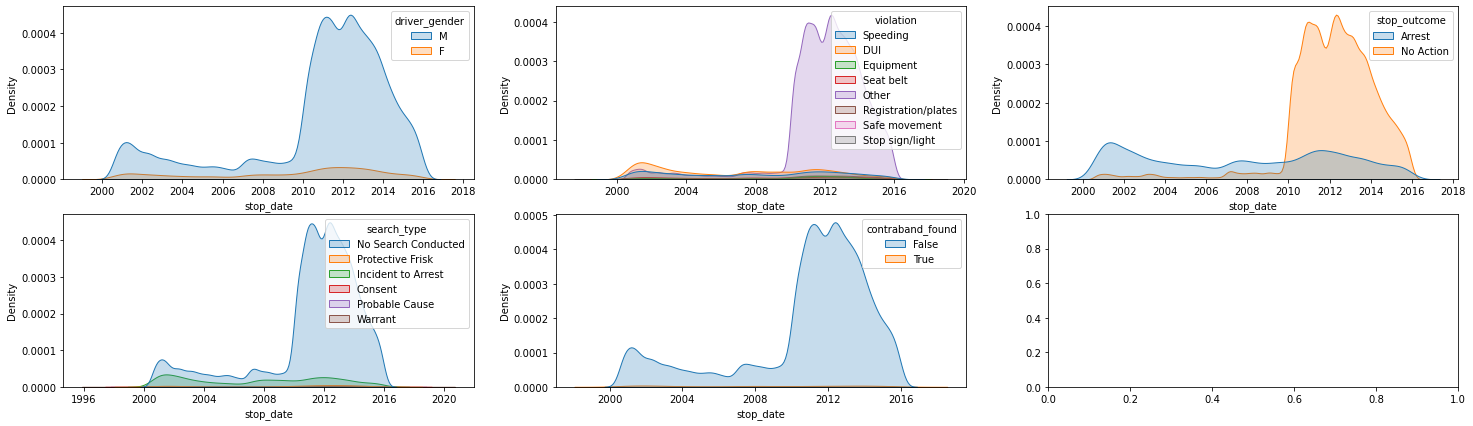

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25,7))
axes = axes.ravel()
for i, col in enumerate(columns):
    sns.kdeplot(data=df, x='stop_date', hue=col, ax=axes[i], fill=True)

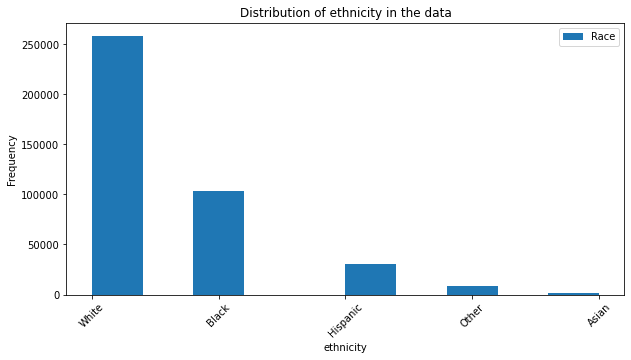

In [14]:
plt.figure(figsize=(10,5))
plt.hist(df['driver_race'], label='Race')
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('ethnicity')
plt.xticks(rotation=45)
plt.title("Distribution of ethnicity in the data")
plt.show()

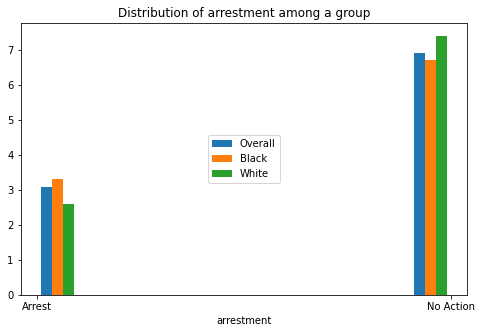

In [15]:
# Distribution of arrestment Scores among a group
df_race = df[['driver_race','stop_outcome']]

#Only African-American
african_am = df_race[df_race['driver_race']=='Black'] 
#Only Caucasians
cauca = df_race[df_race['driver_race']=='White'] 

#Plot the distribution
plt.figure(figsize=(8,5))


plt.hist([df_race['stop_outcome'], african_am['stop_outcome'], cauca['stop_outcome']], density=True, 
           label=['Overall', 'Black', 'White'])

plt.xlabel('arrestment')
plt.title('Distribution of arrestment among a group')
plt.legend(loc='center')
plt.show()

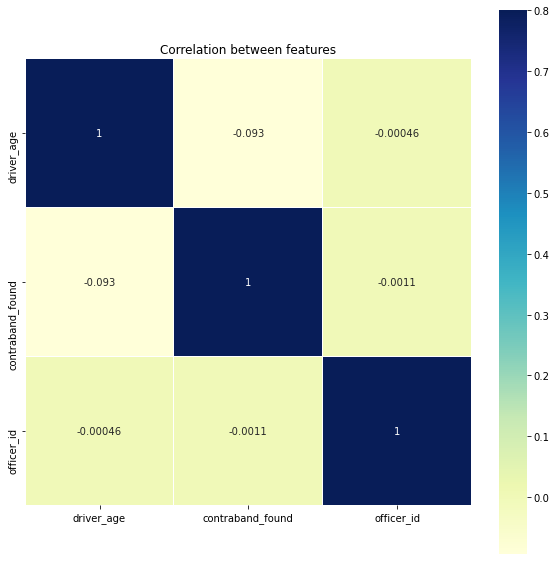

In [16]:
corr = df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features');

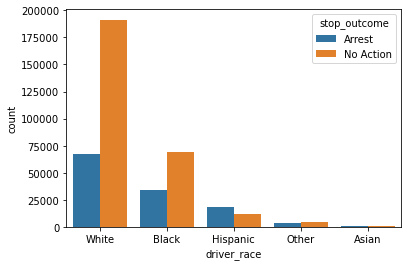

In [17]:
sns.countplot( x='driver_race', hue='stop_outcome', data=df)
plt.show()

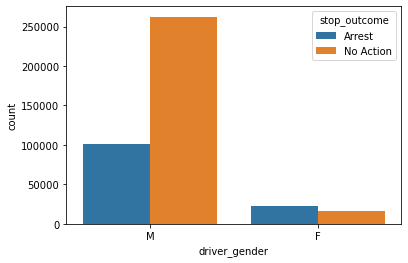

In [18]:
sns.countplot( x='driver_gender', hue='stop_outcome', data=df)
plt.show()

In [19]:
#to keep features low, convert date as a day-difference from the initial day
df['delta_day'] = (df.stop_date - df.stop_date.min()).dt.days

In [20]:
df.head()

,stop_date,driver_gender,driver_age,driver_race,violation,search_type,contraband_found,stop_outcome,search_basis,officer_id,district,delta_day
0,2000-07-31,M,23.0,White,Speeding,No Search Conducted,False,Arrest,No Search Conducted,10606,E3,0
1,2000-07-31,F,29.0,White,Speeding,No Search Conducted,False,Arrest,No Search Conducted,10606,E3,0
2,2000-07-31,F,49.0,Black,Speeding,No Search Conducted,False,Arrest,No Search Conducted,10606,E3,0
3,2000-07-31,M,29.0,Black,Speeding,No Search Conducted,False,Arrest,No Search Conducted,10606,E3,0
4,2000-07-31,M,24.0,Hispanic,Speeding,No Search Conducted,False,Arrest,No Search Conducted,10606,E3,0


In [21]:
df=df.drop(["stop_date"],axis=1)

In [22]:
le=LabelEncoder()
y=le.fit_transform(df.stop_outcome)
pd.DataFrame(data=le.transform(le.classes_), index=le.classes_, columns=["Coding"])

,Coding
Arrest,0
No Action,1


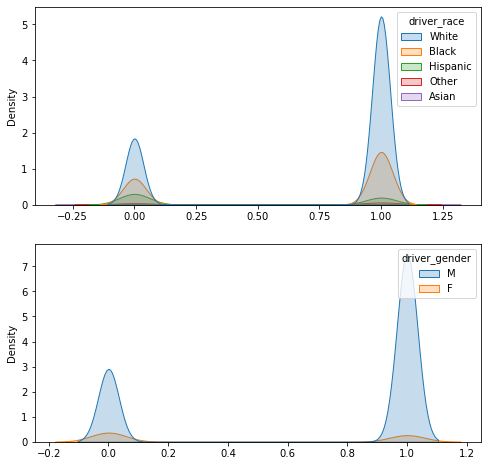

In [23]:
columns=["driver_race","driver_gender"]
fig, axes = plt.subplots(nrows=2, figsize=(8,8))
axes = axes.ravel()
for i, col in enumerate(columns):
    sns.kdeplot(data=df, x=y, hue=col, ax=axes[i], fill=True)
    

In [24]:
#driver_race one hot encoding
X_race = pd.get_dummies(df.driver_race, prefix='race')

In [25]:
X_race.head()

,race_Asian,race_Black,race_Hispanic,race_Other,race_White
0,0,0,0,0,1
1,0,0,0,0,1
2,0,1,0,0,0
3,0,1,0,0,0
4,0,0,1,0,0


In [26]:
#other object types encoding
X_encoded=df[['driver_gender', 'violation',
       'search_type', 'contraband_found', 'search_basis',
        'district']].copy()
X_encoded = X_encoded.apply(le.fit_transform)
X_encoded.head()

,driver_gender,violation,search_type,contraband_found,search_basis,district
0,1,6,2,0,18,34
1,0,6,2,0,18,34
2,0,6,2,0,18,34
3,1,6,2,0,18,34
4,1,6,2,0,18,34


In [27]:
scaler = StandardScaler()
X_num=df[["driver_age","officer_id"]]
X_num.loc[:]=scaler.fit_transform(X_num)

In [28]:
X_num.head()

,driver_age,officer_id
0,-1.450203,-0.008641
1,-0.989287,-0.008641
2,0.547099,-0.008641
3,-0.989287,-0.008641
4,-1.373384,-0.008641


In [29]:
X=pd.concat((X_num, X_encoded, X_race), axis=1)
X.head()

,driver_age,officer_id,driver_gender,violation,search_type,contraband_found,search_basis,district,race_Asian,race_Black,race_Hispanic,race_Other,race_White
0,-1.450203,-0.008641,1,6,2,0,18,34,0,0,0,0,1
1,-0.989287,-0.008641,0,6,2,0,18,34,0,0,0,0,1
2,0.547099,-0.008641,0,6,2,0,18,34,0,1,0,0,0
3,-0.989287,-0.008641,1,6,2,0,18,34,0,1,0,0,0
4,-1.373384,-0.008641,1,6,2,0,18,34,0,0,1,0,0


In [30]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402087 entries, 0 to 402086
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   driver_age        402087 non-null  float64
 1   officer_id        402087 non-null  float64
 2   driver_gender     402087 non-null  int32  
 3   violation         402087 non-null  int32  
 4   search_type       402087 non-null  int32  
 5   contraband_found  402087 non-null  int64  
 6   search_basis      402087 non-null  int32  
 7   district          402087 non-null  int32  
 8   race_Asian        402087 non-null  uint8  
 9   race_Black        402087 non-null  uint8  
 10  race_Hispanic     402087 non-null  uint8  
 11  race_Other        402087 non-null  uint8  
 12  race_White        402087 non-null  uint8  
dtypes: float64(2), int32(5), int64(1), uint8(5)
memory usage: 18.8 MB


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=310)

In [32]:
model,accuracy,f_score,auc_roc,auc_pr=[],[],[],[],[]

In [33]:
xgb_model = XGBClassifier(n_estimators=500).fit(X_train,y_train)
y_pred = xgb_model.predict(X_test)

[09:39:09] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [34]:
model.append("XGB")
acc = accuracy_score(y_test,y_pred)
accuracy.append(acc)
f1=f1_score(y_test, y_pred,average='macro')
f_score.append(f1)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc=metrics.auc(fpr, tpr)
auc_roc.append(roc_auc)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
auc_precision_recall = auc(recall, precision)
auc_pr.append(auc_precision_recall)
print("XGB roc curve auc:", roc_auc)
print("XGB precision-recall curve auc:",auc_precision_recall)
print(classification_report(y_test,y_pred))

XGB roc curve auc: 0.961020274929771
XGB precision-recall curve auc: 0.9843641218763861
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     12318
           1       0.98      0.98      0.98     27891

    accuracy                           0.97     40209
   macro avg       0.96      0.96      0.96     40209
weighted avg       0.97      0.97      0.97     40209



In [35]:
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

In [36]:
model.append("KNN")
knn_acc = accuracy_score(y_test,knn_pred)
accuracy.append(knn_acc)
knn_f1=f1_score(y_test, knn_pred,average='macro')
f_score.append(knn_f1)
knn_fpr, knn_tpr,knn_thresholds = metrics.roc_curve(y_test, knn_pred)
knn_roc_auc=metrics.auc(knn_fpr, knn_tpr)
auc_roc.append(knn_roc_auc)
knn_precision, knn_recall, knn_thresholds = precision_recall_curve(y_test, knn_pred)
knn_auc_precision_recall = auc(knn_recall, knn_precision)
auc_pr.append(knn_auc_precision_recall)
print("knn roc curve auc:", knn_roc_auc)
print("knn precision-recall curve auc:",knn_auc_precision_recall)
print(classification_report(y_test,knn_pred))

knn roc curve auc: 0.9154473472798036
knn precision-recall curve auc: 0.9657596534691125
              precision    recall  f1-score   support

           0       0.91      0.87      0.89     12318
           1       0.94      0.96      0.95     27891

    accuracy                           0.93     40209
   macro avg       0.93      0.92      0.92     40209
weighted avg       0.93      0.93      0.93     40209



In [37]:
dummy_clf = DummyClassifier(strategy="constant",constant=1)
dummy_clf.fit(X_train,y_train)
dum_pred = dummy_clf.predict(X_test)

In [38]:
model.append("Dummy")
dum_acc = accuracy_score(y_test,dum_pred)
accuracy.append(dum_acc)
dum_f1=f1_score(y_test, dum_pred,average='macro')
f_score.append(dum_f1)
dum_fpr, dum_tpr,dum_thresholds = metrics.roc_curve(y_test, dum_pred)
dum_roc_auc=metrics.auc(dum_fpr, dum_tpr)
auc_roc.append(dum_roc_auc)
dum_precision, dum_recall, dum_thresholds = precision_recall_curve(y_test, dum_pred)
dum_auc_precision_recall = auc(dum_recall, dum_precision)
auc_pr.append(dum_auc_precision_recall)
print("dummy roc curve auc:", dum_roc_auc)
print("dummy precision-recall curve auc:",dum_auc_precision_recall)
print(classification_report(y_test,dum_pred))

dummy roc curve auc: 0.5
dummy precision-recall curve auc: 0.8468253376109827
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12318
           1       0.69      1.00      0.82     27891

    accuracy                           0.69     40209
   macro avg       0.35      0.50      0.41     40209
weighted avg       0.48      0.69      0.57     40209



In [39]:
models=pd.DataFrame({"model":model,"accuracy":accuracy,"f_score":f_score,"auc_roc":auc_roc,"auc_pr":auc_pr})
models.head()

,model,accuracy,f_score,auc_roc,auc_pr
0,XGB,0.967147,0.961323,0.961020,0.984364
1,KNN,0.934045,0.921288,0.915447,0.965760
2,Dummy,0.693651,0.409559,0.500000,0.846825


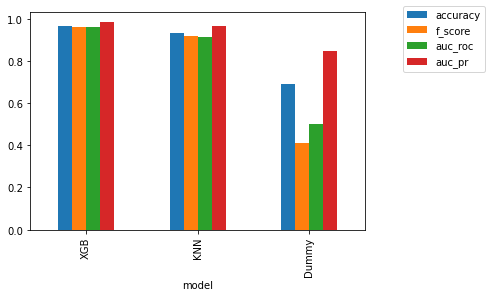

In [40]:
models.plot(x="model", y=["accuracy","f_score","auc_roc","auc_pr"], kind="bar")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

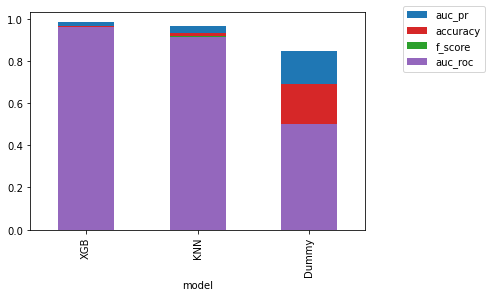

In [41]:
ax = models.plot(x="model", y="auc_pr", kind="bar")
models.plot(x="model", y="accuracy", kind="bar", ax=ax, color="C3")
models.plot(x="model", y="f_score", kind="bar", ax=ax, color="C2")
models.plot(x="model", y="auc_roc", kind="bar", ax=ax, color="C4")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

In [42]:
model_s=models.copy()
model_s=model_s.set_index("model")


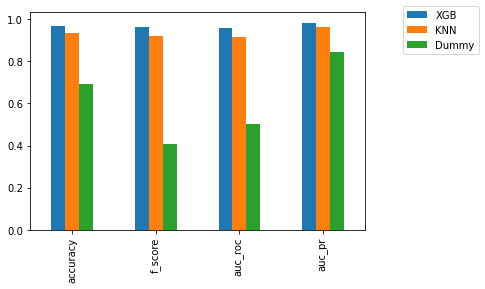

In [43]:
model_s.T.plot(kind="bar")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

In [44]:
def fairness(group_a,group_b,a,b):
    cm_a = confusion_matrix(y_test[group_a], y_pred[group_a])
    cm_b = confusion_matrix(y_test[group_b], y_pred[group_b])

    tn_a, fp_a, fn_a, tp_a = cm_a.ravel()
    tn_b, fp_b, fn_b, tp_b = cm_b.ravel()
    plt.figure()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_a, display_labels=['arrestment','no-arrestment'])
    disp.plot()
    plt.xticks(rotation=45)
    plt.grid(False)
    plt.title(f"Confusion matrix for classifying {a}")
    plt.show()

    plt.figure()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_b, display_labels=['arrestment','no-arrestment'])
    disp.plot()
    plt.xticks(rotation=45)
    plt.grid(False)
    plt.title(f"Confusion matrix for classifying {b}")
    plt.show()
    
    independence_a = (tp_a + fp_a) / (tn_a + fp_a + fn_a + tp_a)
    independence_b = (tp_b + fp_b) / (tn_b + fp_b + fn_b + tp_b)

    print(f'Independence {a}:\t',independence_a)
    print(f'Independence {b}:\t',independence_b)
    print('Independence Difference:\t',independence_a-independence_b)
    
    separation1_a = tp_a / (tp_a + fp_a)
    separation1_b = tp_b / (tp_b + fp_b)
    print(f'1. Separation {a}:\t',separation1_a)
    print(f'1. Separation {b}:\t',separation1_b)
    print('Separation1 Difference:\t',separation1_a-separation1_b)
    
    separation2_a = tn_a / (tn_a + fn_a)
    separation2_b = tn_b / (tn_b + fn_b)
    print(f'2. Separation {a}:\t',separation2_a)
    print(f'2. Separation {b}:\t',separation2_b)
    print('Separation2 Difference:\t',separation2_a-separation2_b)
    
    sufficiency1_a = tp_a / (tp_a + fn_a)
    sufficiency1_b = tp_b / (tp_b + fn_b)
    print(f'1. Sufficiency {a}:',sufficiency1_a)
    print(f'1. Sufficiency {b}:\t',sufficiency1_b)
    print('1. Sufficiency Difference:\t',sufficiency1_a-sufficiency1_b)
    
    sufficiency2_a = fp_a / (fp_a + tn_a)
    sufficiency2_b = fp_b / (fp_b + tn_b)
    print(f'2. Sufficiency {a}:',sufficiency2_a)
    print(f'2. Sufficiency {b}:\t',sufficiency2_b)
    print(f'2. Sufficiency Difference:\t',sufficiency2_a-sufficiency2_b)

<Figure size 432x288 with 0 Axes>

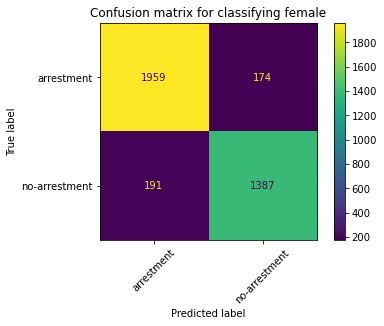

<Figure size 432x288 with 0 Axes>

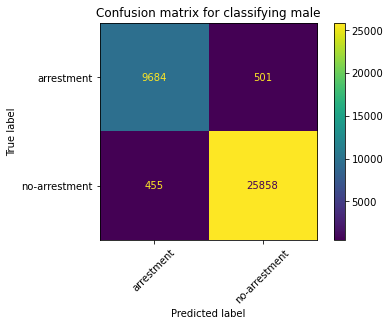

Independence female:	 0.42064133656696306
Independence male:	 0.7222039563811715
Independence Difference:	 -0.30156261981420845
1. Separation female:	 0.8885329916720052
1. Separation male:	 0.9809932091505748
Separation1 Difference:	 -0.09246021747856958
2. Separation female:	 0.9111627906976745
2. Separation male:	 0.9551237794654305
Separation2 Difference:	 -0.043960988767756004
1. Sufficiency female: 0.8789607097591888
1. Sufficiency male:	 0.982708167065709
1. Sufficiency Difference:	 -0.10374745730652013
2. Sufficiency female: 0.08157524613220815
2. Sufficiency male:	 0.0491899852724595
2. Sufficiency Difference:	 0.03238526085974865


In [45]:
group_c = X_test['driver_gender']==0
group_d = X_test['driver_gender']==1
fairness(group_c,group_d,"female","male")

<Figure size 432x288 with 0 Axes>

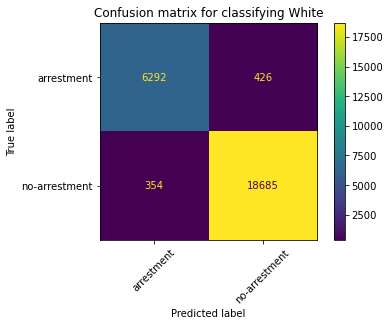

<Figure size 432x288 with 0 Axes>

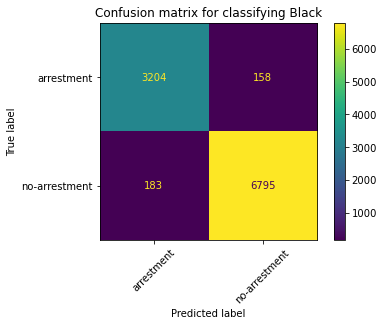

Independence White:	 0.7419730558683076
Independence Black:	 0.6724371373307544
Independence Difference:	 0.06953591853755325
1. Separation White:	 0.9777091727277484
1. Separation Black:	 0.9772759959729613
Separation1 Difference:	 0.00043317675478704576
2. Separation White:	 0.9467348781221787
2. Separation Black:	 0.9459698848538529
Separation2 Difference:	 0.0007649932683257976
1. Sufficiency White: 0.9814065864803824
1. Sufficiency Black:	 0.9737747205503009
1. Sufficiency Difference:	 0.007631865930081472
2. Sufficiency White: 0.06341172968145281
2. Sufficiency Black:	 0.046995835812016655
2. Sufficiency Difference:	 0.016415893869436156


In [46]:
group_a = X_test['race_White']==1
group_b = X_test['race_Black']==1
fairness(group_a,group_b,"White","Black")

<Figure size 432x288 with 0 Axes>

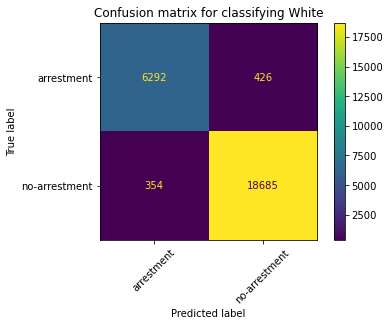

<Figure size 432x288 with 0 Axes>

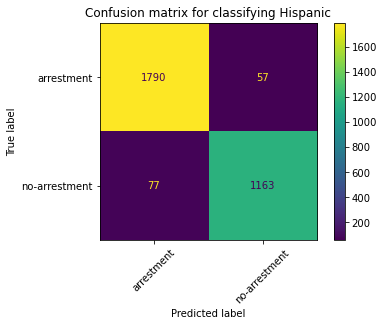

Independence White:	 0.7419730558683076
Independence Hispanic:	 0.3952057013281503
Independence Difference:	 0.34676735454015734
1. Separation White:	 0.9777091727277484
1. Separation Hispanic:	 0.9532786885245902
Separation1 Difference:	 0.024430484203158187
2. Separation White:	 0.9467348781221787
2. Separation Hispanic:	 0.9587573647562935
Separation2 Difference:	 -0.01202248663411476
1. Sufficiency White: 0.9814065864803824
1. Sufficiency Hispanic:	 0.9379032258064516
1. Sufficiency Difference:	 0.04350336067393079
2. Sufficiency White: 0.06341172968145281
2. Sufficiency Hispanic:	 0.03086085544125609
2. Sufficiency Difference:	 0.03255087424019672


In [47]:
group_e = X_test['race_White']==1
group_f = X_test['race_Hispanic']==1
fairness(group_e,group_f,"White","Hispanic")

<Figure size 432x288 with 0 Axes>

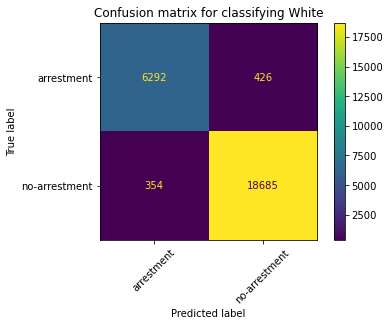

<Figure size 432x288 with 0 Axes>

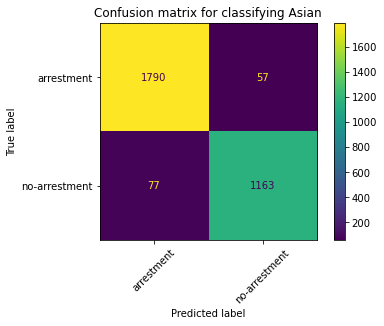

Independence White:	 0.7419730558683076
Independence Asian:	 0.3952057013281503
Independence Difference:	 0.34676735454015734
1. Separation White:	 0.9777091727277484
1. Separation Asian:	 0.9532786885245902
Separation1 Difference:	 0.024430484203158187
2. Separation White:	 0.9467348781221787
2. Separation Asian:	 0.9587573647562935
Separation2 Difference:	 -0.01202248663411476
1. Sufficiency White: 0.9814065864803824
1. Sufficiency Asian:	 0.9379032258064516
1. Sufficiency Difference:	 0.04350336067393079
2. Sufficiency White: 0.06341172968145281
2. Sufficiency Asian:	 0.03086085544125609
2. Sufficiency Difference:	 0.03255087424019672


In [48]:
group_g = X_test['race_White']==1
group_h = X_test['race_Asian']==1
fairness(group_e,group_f,"White","Asian")

In [49]:
#dropping sensitive
X_drop=X.drop(columns=['driver_gender','race_Asian', 'race_Black', 'race_Hispanic', 'race_Other',
       'race_White'],axis=1)

In [50]:
Xd_train, Xd_test, y_train, y_test = train_test_split(X_drop, y, test_size=0.1, random_state=310)

In [51]:
d_xgb_model = XGBClassifier(n_estimators=500).fit(Xd_train,y_train)
dy_pred = d_xgb_model.predict(Xd_test)

[09:39:59] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [52]:
d_acc = accuracy_score(y_test,dy_pred)
print(f"Accuracy score {d_acc}")
d_f1=f1_score(y_test, dy_pred,average='macro')
print(f"f score {d_f1}")
d_fpr, d_tpr, d_thresholds = metrics.roc_curve(y_test, dy_pred)
d_roc_auc=metrics.auc(d_fpr, d_tpr)

d_precision, d_recall, d_thresholds = precision_recall_curve(y_test, dy_pred)
d_auc_precision_recall = auc(d_recall, d_precision)

print("model roc curve auc:", d_roc_auc)
print("model precision-recall curve auc:",d_auc_precision_recall)
print(classification_report(y_test,dy_pred))

Accuracy score 0.9669228282225373
f score 0.9610714495879866
model roc curve auc: 0.9609042607116637
model precision-recall curve auc: 0.9843339132091466
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     12318
           1       0.98      0.98      0.98     27891

    accuracy                           0.97     40209
   macro avg       0.96      0.96      0.96     40209
weighted avg       0.97      0.97      0.97     40209



In [53]:
model

['XGB', 'KNN', 'Dummy']

In [54]:
model_s.T

model,XGB,KNN,Dummy
accuracy,0.967147,0.934045,0.693651
f_score,0.961323,0.921288,0.409559
auc_roc,0.961020,0.915447,0.500000
auc_pr,0.984364,0.965760,0.846825


In [55]:
a={"XGB":{"accuracy":0.967147,"f_score":0.976331,"auc_roc":0.961020,"auc_pr":0.984364},
"XGB_dropped":{"accuracy":0.967147,"f_score":0.961323,"auc_roc":0.961020,"auc_pr":0.984364}}

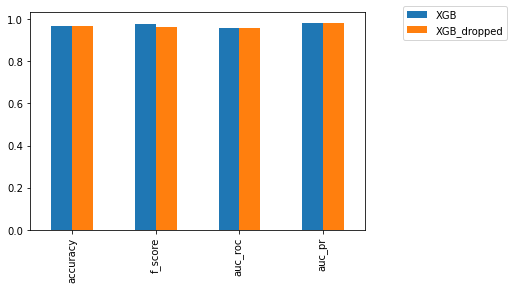

In [56]:
pd.DataFrame(a).plot(kind="bar")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

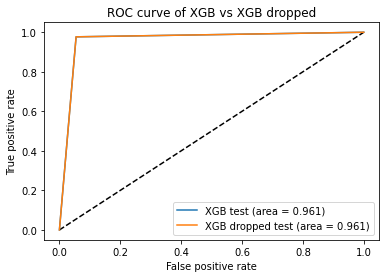

In [57]:
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='XGB test (area = {:.3f})'.format(roc_auc))
plt.plot(fpr, tpr, label='XGB dropped test (area = {:.3f})'.format(d_roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve of XGB vs XGB dropped')
plt.legend(loc='lower right')
plt.show()

In [58]:
le=LabelEncoder()
y=le.fit_transform(df.stop_outcome)
pd.DataFrame(data=le.transform(le.classes_), index=le.classes_, columns=["Coding"])

,Coding
Arrest,0
No Action,1


<Figure size 432x288 with 0 Axes>

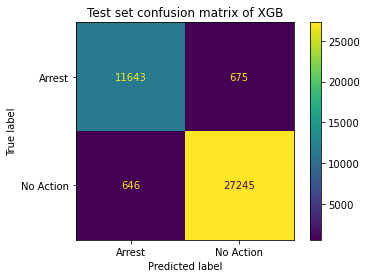

In [59]:
from sklearn.metrics import plot_confusion_matrix

plt.figure()
plot_confusion_matrix(xgb_model, X_test, y_test, display_labels=le.classes_)
plt.title('Test set confusion matrix of XGB')
plt.show()